# Bayesian logistic regression:

In [1]:
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

from coinem.model import AbstractModel
from coinem.dataset import Dataset

/Users/danieldodd/miniconda3/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [ ]:
latent

## Model

We employ standard Bayesian logistic regression with Gaussian priors. That is, we assume that the datapoints’ labels are conditionally independent given the features $f$ and regression weights $x \in \mathbb{R}^{Dy:=9}$, each label with Bernoulli law and mean $s(f^T x)$, where $s(z) := e^z/(1 + e^z)$ denotes the standard logistic function; and we assign the prior $\mathcal{N}(x; \theta I_{D_y}, 5I_{D_y})$ to the weights $x$, where $\theta$ denotes the (scalar) parameter to be estimated. The model’s density is given by:

$$ p_\theta(x, y) = \mathcal{N}(x; \theta I_{D_y}, 5I_{D_y}) \prod_{f, l} s(f^{T} x)^{l} \left[ 1 - s(f^{T} x) \right]^{1-l}$$

### Model in code:
To create our model we just inherit from the provided `AbstractModel`.

In [2]:
import tensorflow_probability.substrates.jax.bijectors as tfb

@dataclass
class LogisticRegression(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D 1"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """

        # Compute linear predictor.
        z = jnp.matmul(data.X, latent)

        # likelihood
        log_lik = tfd.Bernoulli(logits=z).log_prob(data.y.squeeze()).sum()

        # Prior
        log_prior = tfd.Normal(loc=theta[0], scale=5.0).log_prob(latent).sum().squeeze()

        # Compute log-probability.
        return log_lik + log_prior

### Dataset:

We use the Wisconsin Breast Cancer dataset Y (Wolberg and Mangasarian, 1990), created by Dr. William H. Wolberg at the University of Wisconsin Hospitals, and freely available at
https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).
It contains 683 datapoints5 each with nine features f ∈ R9 extracted from a digitized image of a fine needle aspirate of a breast mass and an accompanying label l indicating whether the mass is benign (l = 0) or malign (l = 1). We normalize the features so that each has mean zero and unit standard deviation across the dataset. We split the dataset into 80/20 training and testing sets, Ytrain and Ytest.

In [3]:
# OS and wget to load dataset.
import os
import wget
import numpy as np

# Fetch dataset from repository:
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')

# Load dataset:
dataset = np.loadtxt('breast-cancer-wisconsin.data', dtype=str, delimiter=',')

# Delete local copy of dataset to avoid duplicates with multiple notebook runs:
os.remove('breast-cancer-wisconsin.data')

# Remove datapoints with missing attributes and change dtype to float:
dataset = dataset[~(dataset == '?').any(axis=1), :].astype(float)

# Extract features and labels, and normalize features:
features = np.array(dataset[:, 1:10] - dataset[:, 1:10].mean(0))
features = features/features.std(0)
labels = np.array([(dataset[:, 10]-2)/2]).transpose()

# Split data into 80/20 training and testing sets:
from sklearn.model_selection import train_test_split
ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2, 
                                                random_state=42)

### Unit tests:
We test the score of the latent function and average log-probability of the model.

In [4]:
# Define the model:
model = LogisticRegression()
data = Dataset(ftrain, ltrain)

# Unit tests:
N = 10  # Number of particles.
D = 9  # Dimension of latent space.

theta = jnp.array([0.0]) # Parameters of the model.
latent_particles = jnp.zeros((N, D)) # Latent particles.

f = ftrain # Features
y = ltrain # Labels

s = 1.0/(1.0+jnp.exp(-jnp.matmul(f, latent_particles.T)))
score_latent_particles = (jnp.matmul((y-s).T, f).T - (latent_particles.T)/5).T
average_score_theta = jnp.array([[2 * (latent_particles.T).sum(0).mean()/5]])

assert jnp.allclose(model.score_latent_particles(latent_particles, theta, data), score_latent_particles) # Gradient of log p(y|x) wrt latent particles
assert jnp.allclose(model.average_score_theta(latent_particles, theta, data), average_score_theta) # Average gradient of log p(y|x) wrt theta

### VI model

In [6]:
# def softplus(x):
#     return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

# def vi(l, f, h, K, N, th, X, mu=None):
#   D = f[0, :].size  # Extract latent variable dimension.
#   mu = np.zeros(D) if mu is None else mu
#   z = np.ones(D)
#   for k in range(K):
#     # update q
#     def loss(mu, z):
#       s2 = softplus(z)
#       x = (np.random.normal(0, 1, (N, D)) * s2 ** 0.5  + mu).T
#       log_prior =  - np.sum((x - th[k]) ** 2, 0) / 5  # Shape (N)
#       log_likel =  l * np.matmul(f, x) - np.log(1 + np.exp(np.matmul(f, x)))  # (M, N)
#       log_prob = np.sum(log_likel, 0)
#       entropy = 0.5 * np.sum(np.log(s2))
#       return np.mean(log_prob + log_prior, 0) + entropy
#     step_size = h
#     mu, z = mu + step_size * grad(loss, 0)(mu, z), z + step_size * grad(loss, 1)(mu, z)
#     s2 = softplus(z)
#     Xk = (np.random.normal(0, 1, (N, D)) * s2 ** 0.5 + mu).T
#     # update theta
#     th = np.append(th, th[k] + h*ave_grad_th(th[k], Xk))
#     X = np.append(X, Xk, axis=1) # Store updated cloud.
#   return th, X, mu, softplus(z)

# Experiment 1 (Theta estimate example - Kuntz et al.)

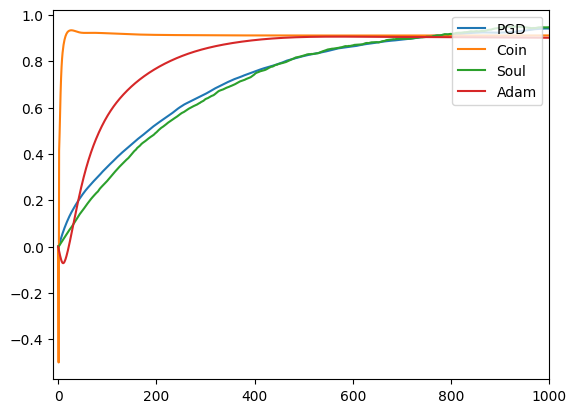

In [6]:
from coinem.zoo import coin_svgd, pgd, soul, adam_svgd

import jax.random as jr
key = jr.PRNGKey(42)

h = 1e-2 # Step-size. 
K = 1000  # Number of steps.
N = 10  # Number of particles.


th0 = jnp.array([0.0, tfb.Softplus().inverse(5.0)])  # Parameter estimate.
X0 = jr.normal(key, (N, D))  # Particle cloud.

X_coin, th_coin = coin_svgd(model, data, X0, th0, K)
X_pgd, th_pgd = pgd(model, data, X0, th0, K, latent_step_size=1e-2, theta_step_size=1e-2)
X_soul, th_soul = soul(model, data, X0, th0, K, latent_step_size=1e-2, theta_step_size=1e-2)
X_adam, th_adam = adam_svgd(model, data, X0, th0, K, latent_step_size=1e-2, theta_step_size=1e-2)


plt.plot(th_pgd[:, 0].squeeze(), label='PGD')
plt.xlim([-K/100, K])
plt.plot(th_coin[:, 0].squeeze(), label='Coin')
plt.plot(th_soul[:, 0].squeeze(), label='Soul')
plt.plot(th_adam[:, 0].squeeze(), label='Adam')
plt.legend(loc='upper right')
plt.show()

# Experiment 2 (Joint learning rate analysis on predictive performance)

- We run this for 10 different seeds for 100 different learning rates / step sizes
- Each replication has a different train test split.

In [143]:
from coinem.zoo import coin_svgd, pgd, soul, adam_svgd

import jax.random as jr
from jax import vmap

# Random seeds for reproducibility:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Learning rates:
theta_step_sizes = jnp.logspace(-10, 2, num=100)
latent_step_sizes = jnp.logspace(-10, 2, num=100)

K = 500  # Number of steps.
N = 10  # Number of particles.

coin_errors = []
adam_errors = []
pgd_errors = []
soul_errors = []

coin_lppd = []
adam_lppd = []
pgd_lppd = []
soul_lppd = []

def predict_prob(f, X):
    """Returns label maximizing the approximate posterior predictive 
    distribution defined by the cloud X, vectorized over feature vectors f.
    """
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(f, x)).mean())(X).mean(0)
    return s

def test_error(f, l, X):
    """Returns fraction of misclassified test points."""

    s = predict_prob(f, X)
    pred = np.zeros((f[:, 0].size, 1))
    pred[s >= 1/2] = 1
    return np.abs(l - pred).mean()


def lppd(f, l, X):
    """Returns log pointwise predictive density."""
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(f, x)).log_prob(l.squeeze()) )(X).mean()
    return s


for seed in seeds:
    
    ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2,random_state=seed)

    model = LogisticRegression()
    data = Dataset(ftrain, ltrain)

    key = jr.PRNGKey(seed)

    key, subkey = jr.split(key)


    th0 = jnp.array([0.0])  # Parameter estimate.
    X0 = jr.normal(subkey, (N, D))  # Particle cloud.

    x_coin, th_coin  = coin_svgd(model, data, X0, th0, K)

    coin_errors.append(test_error(ftest, ltest, x_coin[-1]))
    coin_lppd.append(lppd(ftest, ltest, x_coin[-1]))


    for theta_step, latent_step in zip(theta_step_sizes, latent_step_sizes):

        key_pgd, key_soul = jr.split(key)

        x_adam, th_adam = adam_svgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step)
        X_pgd, th_pgd = pgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_pgd)
        X_soul, th_soul = soul(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_soul)
        

        adam_errors.append(test_error(ftest, ltest, x_adam[-1]))
        pgd_errors.append(test_error(ftest, ltest, X_pgd[-1]))
        soul_errors.append(test_error(ftest, ltest, X_soul[-1]))

        adam_lppd.append(lppd(ftest, ltest, x_adam[-1]))
        pgd_lppd.append(lppd(ftest, ltest, X_pgd[-1]))
        soul_lppd.append(lppd(ftest, ltest, X_soul[-1]))


# Reshape results:
coin_errors = jnp.array(coin_errors)
adam_errors = jnp.array(adam_errors).reshape(-1, theta_step_sizes.shape[0])
pgd_errors = jnp.array(pgd_errors).reshape(-1, theta_step_sizes.shape[0])
soul_errors = jnp.array(soul_errors).reshape(-1, theta_step_sizes.shape[0])


coin_lppd = jnp.array(coin_lppd)
adam_lppd = jnp.array(adam_lppd).reshape(-1, theta_step_sizes.shape[0])
pgd_lppd = jnp.array(pgd_lppd).reshape(-1, theta_step_sizes.shape[0])
soul_lppd = jnp.array(soul_lppd).reshape(-1, theta_step_sizes.shape[0])


### (a) Errors averaged over all the replications

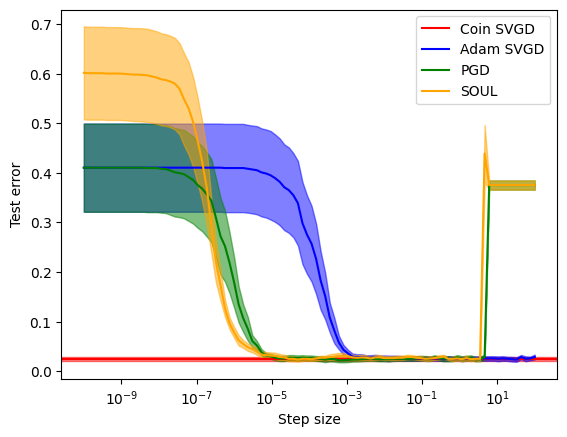

In [144]:
plt.axhline(coin_errors.mean(), color='r', label='Coin SVGD')
plt.axhspan(coin_errors.mean() - coin_errors.std()/jnp.sqrt(10), coin_errors.mean() + coin_errors.std()/jnp.sqrt(10), alpha=0.5, color='r')

plt.plot(theta_step_sizes, adam_errors.mean(0), label='Adam SVGD', color='b')
plt.fill_between(theta_step_sizes, adam_errors.mean(0) - adam_errors.std(0)/jnp.sqrt(10), adam_errors.mean(0) + adam_errors.std(0)/jnp.sqrt(10), alpha=0.5, color='b')

plt.plot(theta_step_sizes, pgd_errors.mean(0), label='PGD', color='g')
plt.fill_between(theta_step_sizes, pgd_errors.mean(0) - pgd_errors.std(0)/jnp.sqrt(10), pgd_errors.mean(0) + pgd_errors.std(0)/jnp.sqrt(10), alpha=0.5 , color='g')


plt.plot(theta_step_sizes, soul_errors.mean(0), label='SOUL' , color='orange')
plt.fill_between(theta_step_sizes, soul_errors.mean(0) - soul_errors.std(0)/jnp.sqrt(10), soul_errors.mean(0) + soul_errors.std(0)/jnp.sqrt(10), alpha=0.5 , color='orange')
plt.xscale('log')
plt.xlabel('Step size')
plt.ylabel('Test error')
plt.legend()
plt.savefig('figs/logistic_regression_a.pdf')

### (b) Log predictive denisty:

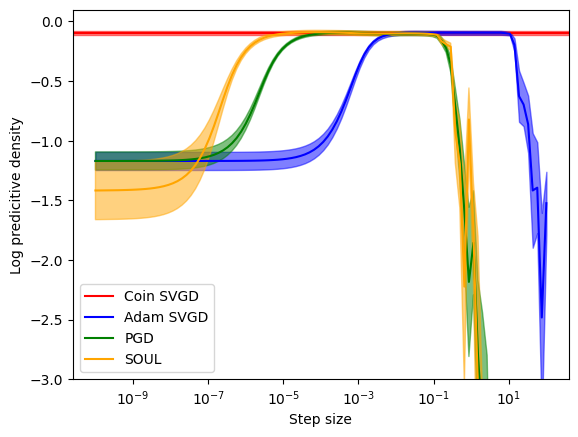

In [154]:
plt.axhline(coin_lppd.mean(), color='r', label='Coin SVGD')
plt.axhspan(coin_lppd.mean() - coin_lppd.std()/jnp.sqrt(10), coin_lppd.mean() + coin_lppd.std()/jnp.sqrt(10), alpha=0.5, color='r')

plt.plot(theta_step_sizes, adam_lppd.mean(0), label='Adam SVGD', color='b')
plt.fill_between(theta_step_sizes, adam_lppd.mean(0) - adam_lppd.std(0)/jnp.sqrt(10), adam_lppd.mean(0) + adam_lppd.std(0)/jnp.sqrt(10), alpha=0.5, color='b')

plt.plot(theta_step_sizes, pgd_lppd.mean(0), label='PGD', color='g')
plt.fill_between(theta_step_sizes, pgd_lppd.mean(0) - pgd_lppd.std(0)/jnp.sqrt(10), pgd_lppd.mean(0) + pgd_lppd.std(0)/jnp.sqrt(10), alpha=0.5 , color='g')


plt.plot(theta_step_sizes, soul_lppd.mean(0), label='SOUL' , color='orange')
plt.fill_between(theta_step_sizes, soul_lppd.mean(0) - soul_lppd.std(0)/jnp.sqrt(10), soul_lppd.mean(0) + soul_lppd.std(0)/jnp.sqrt(10), alpha=0.5 , color='orange')
plt.xscale('log')
plt.xlabel('Step size')
plt.ylabel('Log predicitive density')
plt.legend()
plt.ylim(-3, 0.1)

plt.savefig('figs/logistic_regression_b.pdf')

While for a given replicate, there is a learning rate that outperforms coin in this example, but varying the test train split, we see that coin is robust!

# Experiment 3 (Seperate learning rates for latent, and hyperparameters)

For a given test train split, we plot the relative peformance to the coin algorithm vs competitor as a contour plot for varying the lengthscale on both the latent and on theta.

In [198]:
seed = 42

ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2,random_state=seed)

# Learning rates:
theta_step_sizes = jnp.logspace(-10, 2, num=50)
latent_step_sizes = jnp.logspace(-10, 2, num=50)

# Number of iterations:
K = 1000

# Number of particles:
N = 10


coin_errors = []
adam_errors = []
pgd_errors = []
soul_errors = []

coin_lppd = []
adam_lppd = []
pgd_lppd = []
soul_lppd = []


def predict_prob(f, X):
    """Returns label maximizing the approximate posterior predictive 
    distribution defined by the cloud X, vectorized over feature vectors f.
    """
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(f, x)).mean())(X).mean(0)
    return s

def test_error(f, l, X):
    """Returns fraction of misclassified test points."""

    s = predict_prob(f, X)
    pred = np.zeros((f[:, 0].size, 1))
    pred[s >= 1/2] = 1
    return np.abs(l - pred).mean()


def lppd(f, l, X):
    """Returns log pointwise predictive density."""
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(f, x)).log_prob(l.squeeze()) )(X).mean()
    return s


model = LogisticRegression()
data = Dataset(ftrain, ltrain)

key = jr.PRNGKey(seed)

key, subkey = jr.split(key)


th0 = jnp.array([0.0])  # Parameter estimate.
X0 = jr.normal(subkey, (N, D))  # Particle cloud.

x_coin, th_coin  = coin_svgd(model, data, X0, th0, K)

coin_errors.append(test_error(ftest, ltest, x_coin[-1]))
coin_lppd.append(lppd(ftest, ltest, x_coin[-1]))

for theta_step in theta_step_sizes:
    for latent_step in latent_step_sizes:
        
        key_pgd, key_soul = jr.split(key)

        x_adam, th_adam = adam_svgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step)
        X_pgd, th_pgd = pgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_pgd)
        X_soul, th_soul = soul(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_soul)
        

        adam_errors.append(test_error(ftest, ltest, x_adam[-1]))
        pgd_errors.append(test_error(ftest, ltest, X_pgd[-1]))
        soul_errors.append(test_error(ftest, ltest, X_soul[-1]))

        adam_lppd.append(lppd(ftest, ltest, x_adam[-1]))
        pgd_lppd.append(lppd(ftest, ltest, X_pgd[-1]))
        soul_lppd.append(lppd(ftest, ltest, X_soul[-1]))

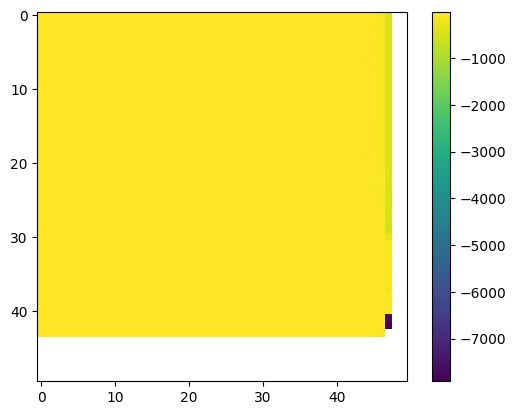

In [207]:
z = jnp.array(pgd_lppd) - jnp.array(coin_errors)
x = jnp.array(theta_step_sizes)
y = jnp.array(latent_step_sizes)
Z = z.reshape(50, 50)
plt.imshow(Z)
plt.colorbar()

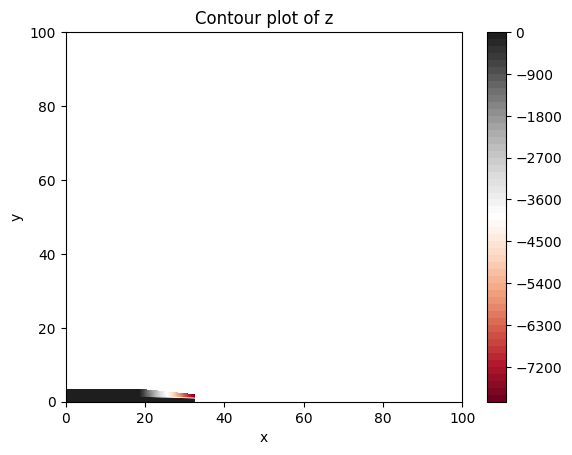

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# create a grid of x and y values
X, Y = np.meshgrid(x, y)

# reshape z into a grid
Z = z.reshape(50, 50)

# create a contour plot
plt.contourf(X, Y, Z, levels=70, cmap='RdGy')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour plot of z')
plt.show()
